### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/CI2020-hackathon/James/'

Mounted at /gdrive


In [ ]:
device='gpu' # 'tpu'/'gpu'

In [ ]:
if device=='gpu':
  gpu_info = !nvidia-smi
  print('\n'.join(gpu_info))
  device='cuda'

Fri Sep 25 10:07:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data

In [ ]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import pandas as pd
import torch
import time
import pandas as pd
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
CloudTop = np.load("../public_data/X_train_CI20.npy")
TrueColor = np.load("../public_data/Y_train_CI20.npy")
TrueColor.shape, CloudTop.shape

((8423, 127, 127, 3), (8423, 127, 127, 3))

### Preprocessing

Get rid of dark images

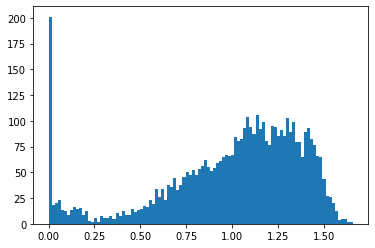

In [ ]:
mask = np.where(np.sum(TrueColor,axis=(1,2,3))>0.)
TrueColorNZ = TrueColor[mask]
CloudTopNZ = CloudTop[mask]

# examine average intensities
saturation = ( TrueColorNZ.mean(axis=(1,2)) / (TrueColorNZ.mean(axis=(1,2)).mean(0)) ).mean(axis=1)
plt.hist(saturation, bins=100);
plt.show()

In [ ]:
# cutoff intensity
min_saturation = 0.6

TrueColorNZ = TrueColorNZ[saturation > min_saturation]
CloudTopNZ = CloudTopNZ[saturation > min_saturation]

In [ ]:
TrueColorNZ.shape, CloudTopNZ.shape

((3880, 127, 127, 3), (3880, 127, 127, 3))

In [ ]:
del CloudTop, TrueColor



## U-Net++

In [ ]:
from lib.unet_plus import NestedUNet
from lib.ssim import SSIM

calc_ssim = SSIM()
loss_fn = lambda x1, x2: -calc_ssim(x1,x2)

In [ ]:
model = NestedUNet(num_classes=3, input_channels=3, deep_supervision=False, nb_filter=[8, 16, 32, 64, 128],).to(device)
optim = torch.optim.Adam(model.parameters())

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
              ReLU-3          [-1, 8, 128, 128]               0
            Conv2d-4          [-1, 8, 128, 128]             584
       BatchNorm2d-5          [-1, 8, 128, 128]              16
              ReLU-6          [-1, 8, 128, 128]               0
          VGGBlock-7          [-1, 8, 128, 128]               0
         MaxPool2d-8            [-1, 8, 64, 64]               0
            Conv2d-9           [-1, 16, 64, 64]           1,168
      BatchNorm2d-10           [-1, 16, 64, 64]              32
             ReLU-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 16, 64, 64]           2,320
      BatchNorm2d-13           [-1, 16, 64, 64]              32
             ReLU-14           [-1, 16,

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

def pad(data):
  return F.pad(input=data, pad=(0, 1, 0, 1), mode='constant', value=0)

In [ ]:
batch_size = 10
test_size=500

tensor_x = pad(torch.from_numpy(CloudTopNZ.transpose((0,3,1,2))/255))
tensor_y = torch.from_numpy(TrueColorNZ.transpose((0,3,1,2))/255.)

dataset = TensorDataset(tensor_x,tensor_y)

# split into train and test sets and create dataloader
train_set, test_set = torch.utils.data.random_split(dataset, (len(dataset)-test_size, test_size), generator=torch.Generator().manual_seed(42))
dataloader = DataLoader(train_set, batch_size=batch_size)

test_X, test_y = test_set[:]
test_X = test_X.to(device)
test_y = test_y.to(device)

del tensor_x, tensor_y, train_set, test_set, dataset, CloudTopNZ, TrueColorNZ

In [ ]:
dataloader.dataset.dataset.tensors[0].device

device(type='cpu')

In [ ]:
STATS_PERIOD = 50
MODEL_DUMP_ROOT="output_dump"

N=50

class net_container:
    def __init__(self, net, optimizer, loss_func, test_X, test_y, run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        self.test_X = test_X
        self.test_y = test_y
        
        self.running_train_loss = 0
        self.train_losses = []
        self.test_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, X, y, batch_number):
        


        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net(X)[:,:,:-1, :-1]
        train_loss = self.loss_func(outputs, y)

        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()

        # zero the parameter gradients
        self.optimizer.zero_grad()

        del outputs, train_loss

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            
            self.running_train_loss = 0.

            # Test loss
            self.net.eval()
            
            test_loss=0
            for i in range((self.test_X.shape[0]-1)//N + 1):
              test_outputs = self.net(self.test_X[i*N:(i+1)*N])[:,:,:-1, :-1]
              l = self.loss_func(test_outputs, self.test_y[i*N:(i+1)*N]).item()
              l = l * min(N, self.test_X.shape[0]-i*N)/self.test_X.shape[0]
              test_loss += l

            self.test_losses.append(test_loss)
           
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)

            print(f"batch {batch_number} | {self.time_elapsed[-1]}s elapsed | train_loss {mean_train_loss:.5f} | test_loss {self.test_losses[-1]:.5f}"+" "*10, flush=True)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(thisdir)
                    
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'test_loss':self.test_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))

In [ ]:
wrapped_model = net_container(model, optim, loss_fn, test_X, test_y, run_name='unet8')

bn = 0

In [ ]:
batch_epochs=[(10, 60), (32, 30), (64, 30), (128, 20), (256, 20)]

for batch_size, epochs in batch_epochs:

  print(f"transition to (batch:{batch_size}, epochs: {epochs})")
  dataloader = DataLoader(dataloader.dataset, batch_size=batch_size)

  for _ in range(epochs):
      
      for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          wrapped_model.train_step(X,y,bn)
          bn+=1

## Evaluate and reload best model

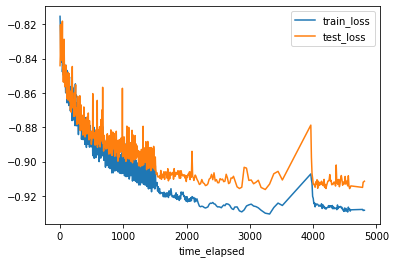

In [ ]:
df = pd.read_csv('output_dump/unet5/training_stats.csv')
df = df[df.train_loss>-1]
df.plot(x='time_elapsed', y=['train_loss', 'test_loss'])

In [ ]:
df.test_loss.min()

-0.9162882685661314

We ran this notebook a number of times with different values for `min_saturation`. UNet5 has the value shown in this notebook and turned out to score the best on the validation set.

In [ ]:
model5 = torch.load('output_dump/unet5/best_model.pkl')
model5.eval();

model7 = torch.load('output_dump/unet7/best_model.pkl')
model7.eval();

model8 = torch.load('output_dump/unet8/best_model.pkl')
model8.eval();

In [ ]:
model=model5

In [ ]:
scores = []
for i in range(len(test_X)):
             scores += [loss_fn(model(test_X[i:i+1])[:,:, :-1, :-1], test_y[i:i+1]).item()]

/gdrive/My Drive/CI2020-hackathon/James/lib/ssim.py:23: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  mu1_mu2 = mu1*mu2
/gdrive/My Drive/CI2020-hackathon/James/lib/ssim.py:25: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq


In [ ]:
indexes = [x[0] for x in sorted([(i,s) for i,s in enumerate(scores)], key=lambda x: x[1])][::-1]

(array([ 59., 141., 107.,  81.,  29.,  26.,  18.,  10.,   6.,   4.,   3.,
          1.,   5.,   2.,   1.,   0.,   0.,   2.,   1.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([-0.96975535, -0.95356143, -0.9373675 , -0.92117357, -0.90497965,
        -0.88878572, -0.87259179, -0.85639787, -0.84020394, -0.82401001,
        -0.80781609, -0.79162216, -0.77542824, -0.75923431, -0.74304038,
        -0.72684646, -0.71065253, -0.6944586 , -0.67826468, -0.66207075,
        -0.64587682, -0.6296829 , -0.61348897, -0.59729505, -0.58110112,
        -0.56490719, -0.54871327, -0.53251934, -0.51632541, -0.50013149,
        -0.48393756]),
 <a list of 30 Patch objects>)

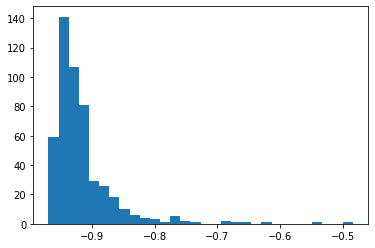

In [ ]:
plt.hist(scores, bins=30)

In [ ]:
np.median(scores)

-0.9301941394805908

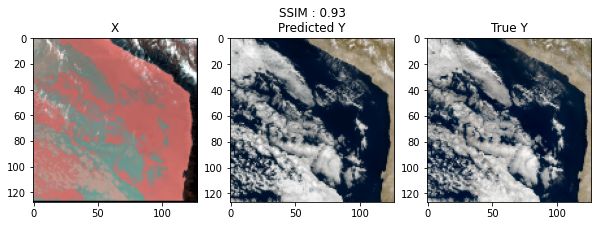

In [ ]:
randindex = indexes[266]

img_y_hat = model(test_X[randindex:randindex+1])[:,:, :-1, :-1]
img_y = test_y[randindex:randindex+1,:,:,:]
img_x = test_X[randindex:randindex+1,:,:,:]

def post_process(imgs):
  return imgs[0].detach().cpu().numpy().transpose((1,2,0))*255


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(array_to_img(post_process(img_x)))
plt.title('X')

plt.subplot(1,3,2)
plt.imshow(array_to_img(post_process(img_y_hat)))
plt.title(f'SSIM : {-loss_fn(img_y_hat, img_y):.2f}\nPredicted Y')

plt.subplot(1,3,3)
plt.imshow(array_to_img(post_process(img_y)))
plt.title('True Y')

plt.savefig('median_example.png', dpi=600)

In [ ]:
X_test = np.load("../public_data/NightVision.npy")
X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)

predictions5 = model5(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255
predictions7 = model7(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255
predictions8 = model8(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255

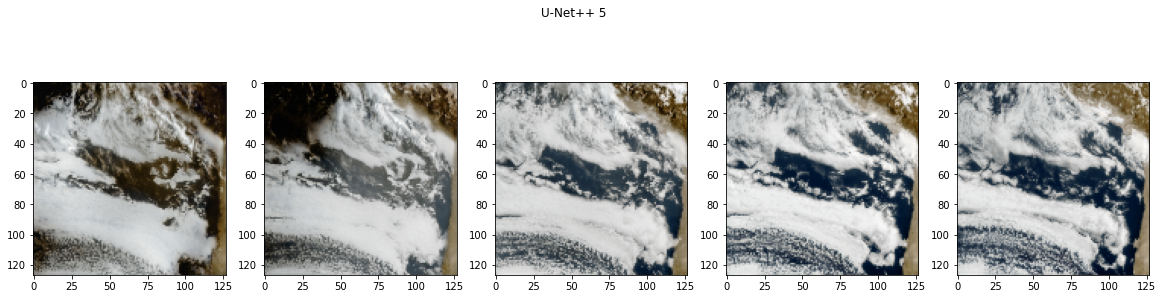

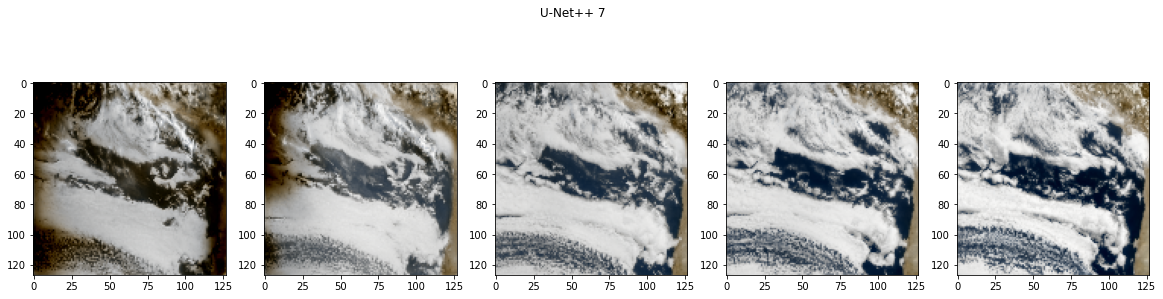

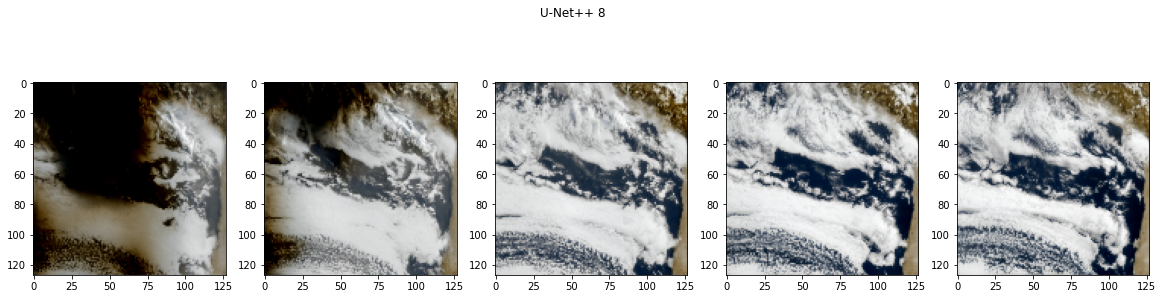

In [ ]:
ind=10
n=5

plt.figure(figsize=(20,5))
plt.suptitle('U-Net++ 5')

for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(array_to_img(predictions5[ind+i]))

plt.figure(figsize=(20,5))
plt.suptitle('U-Net++ 7')

for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(array_to_img(predictions7[ind+i]))

plt.figure(figsize=(20,5))
plt.suptitle('U-Net++ 8')
for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(array_to_img(predictions8[ind+i]))


The figure above shows the predicted RBG images for the nighttime IR inuts. Our training data for each of these U-Net++ models had differening thresholds for excluding images. The higher the threshld, the less amount of darkness the network predicted.

We do better thresholding in the following notebooks.

In [ ]:
predictions_file = "predictions"

def save_compress(predictions, name):
    np.save(f'{predictions_file}/{name}.npy', predictions)
    os.system(f"mv {predictions_file}/{name}.npy {predictions_file}/{name}.predict")
    os.system(f"zip -jrm {predictions_file}/{name}.zip {predictions_file}/{name}.predict")
    os.system(f"rm {predictions_file}/{name}.predict")

save_compress(predictions5, 'Y_NightVision_stargazer')